In [ ]:
# default setting
import os
import pickle
from tqdm import tqdm

# preprosessing
import numpy as np
import pandas as pd
import datetime as dt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

# model pred
from lightgbm import LGBMClassifier
from lightgbm import plot_importance
from sklearn.metrics import accuracy_score

# model interpretor
import lime
import lime.lime_tabular


os.chdir(r'N:\[03] 단기 작업\빅콘 테스트')
print('data import')
full_data_train = pd.read_csv('full_data_train_2.csv')
full_data_test = pd.read_csv('full_data_test_2.csv')


In [2]:
# preprocessing
print('train preprocessing')
# 먼저 train에 대해 작업

# 나이로 변환.
age = 2022 - full_data_train.birth_year

# 이러면 입사한지 몇일 되었는지 반환된다.
employdate = dt.datetime.now() - pd.to_datetime(full_data_train.company_enter_month, format = '%Y%m')
employdate = employdate.apply(lambda x : x.days)

# 버리는 라인
# 입사년 # 입사월
# full_data_test.company_enter_month.astype(str).str[:4]; full_data_test.company_enter_month.astype(str).str[4:6]

# 시간차이. - 최대 37일, 최소 1초 -> 근데 이거 써야할까?
# pd.to_datetime(full_data_test.loanapply_insert_time) - pd.to_datetime(full_data_test.insert_time)

# 무쓸모하다고 판단되어짐.
# loanapply insert time (분석제거)
# insert time (분석제거) / ymd (insert time 파생변수) -- 세 변수 모두 어짜피 년 고정, 월만 4-6월인데 중요할까? 아닌것 같음.

# 무쓸모, 다만 저장(인덱스 역할) -> 이 처리 이후로 인덱스 꼬이면 안됨.
# application_id
# user_id

# 대체 후 제거
# birth_year
# company enter month

# df setting
full_data_train['employ_date'] = employdate
full_data_train['age'] = age
full_data_train = full_data_train.drop(['loanapply_insert_time', 'insert_time', 'company_enter_month', 'birth_year'], axis = 1)

train_appid = full_data_train.pop('application_id')
train_usrid = full_data_train.pop('user_id')
train_target = full_data_train.pop('is_applied')

train preprocessing


In [3]:
# 먼저 test에 대해 동일 작업.
print('test preprocessing')
# 나이로 변환.
age = 2022 - full_data_test.birth_year

# 이러면 입사한지 몇일 되었는지 반환된다.
employdate = dt.datetime.now() - pd.to_datetime(full_data_test.company_enter_month, format = '%Y%m')
employdate = employdate.apply(lambda x : x.days)

# df setting
full_data_test['employ_date'] = employdate
full_data_test['age'] = age
full_data_test = full_data_test.drop(['loanapply_insert_time', 'insert_time', 'company_enter_month', 'birth_year'], axis = 1)

test_appid = full_data_test.pop('application_id')
test_usrid = full_data_test.pop('user_id')
test_target = full_data_test.pop('is_applied')

del employdate, age

test preprocessing


In [4]:

print('label_Encoding')
# 형 변환 준비.

# feature names에 personal_rehabilitation_complete_yn, personal_rehabilitation_yn 넣을건지.
feature_names = full_data_train.columns

cat_feature_names = ['bank_id', 'product_id', 'gender', 'income_type', 'employment_type',
                     'houseown_type', 'purpose', 'latest_os', 'latest_version', 'personal_rehabilitation']
categorical_features = [idx for idx, val in enumerate(full_data_train.columns) if val in cat_feature_names]

num_features_names = [val for idx, val in enumerate(full_data_train.columns) if val not in cat_feature_names]
numeric_features = [idx for idx, val in enumerate(full_data_train.columns) if val not in cat_feature_names]

# 형 변환을 위한 훈련 샘플 추가
full_data = pd.concat([full_data_train, full_data_test], axis = 0)

# train 변환.
categorical_names = {}
for feature in categorical_features:
    le = LabelEncoder()
    le.fit(full_data.iloc[:, feature])
    full_data_train.iloc[:, feature] = le.transform(full_data_train.iloc[:, feature])
    full_data_test.iloc[:, feature] = le.transform(full_data_test.iloc[:, feature])
    categorical_names[feature] = le.classes_

del full_data, le


label_Encoding


In [5]:
print('Onehot, standard X')
# 형 변환을 위한 훈련 샘플 (라벨 인코딩 변현됬으니 새로 생성.)
full_data = pd.concat([full_data_train, full_data_test], axis = 0)

from sklearn.compose import ColumnTransformer

# categorical_features => cat_feature_names로 변경됨. => importance plot의 라벨값 꺼내기 위해서.
encoder = ColumnTransformer([("enc", OneHotEncoder(), categorical_features)], remainder = 'passthrough')
encoder.fit(full_data)

del full_data


Onehot, standard X


In [6]:
# 데이터 표준화
std_enc = StandardScaler()
full_data_train.loc[:, num_features_names] = std_enc.fit_transform(full_data_train.loc[:, num_features_names])
full_data_test.loc[:, num_features_names] = std_enc.transform(full_data_test.loc[:, num_features_names])

In [7]:
print('Data Undersampling')

rus = RandomUnderSampler()
undersampled_data, undersampled_target = rus.fit_resample(full_data_train, train_target)
# 이순간 train에 있는 appid, usrid는 사용하지 못함

# Sparse Matrix can be used to fit a lot of models, eg. XGBoost, LightGBM, Random Forest, K-Means and etc. -> 즉 트리 훈련에는 무관.
X_train, X_valid, y_train, y_valid = train_test_split(undersampled_data, undersampled_target, test_size=0.2, stratify = undersampled_target)

Data Undersampling


In [8]:
# 일단 훈련하기위해 데이터를 변환시킴.
encoded_train = encoder.transform(X_train)
encoded_train = encoded_train.toarray()

# csr matrix로 안만들면 연산 불가능함. -> 일단 CSR 처리해봐. (원래라면 onehot 인코더 매개변수로 sparse=False 들어가야함.)
# columnTransfomer 에 임계값(sparse_threshold=0)에서 걸러도 가능.

C:\Users\Nyoths\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

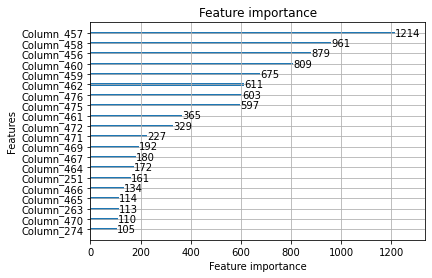

In [9]:
model = LGBMClassifier(n_estimators=400)
model.fit(encoded_train, y_train, verbose = 1)

plot_importance(model, max_num_features = 20)

모델의 ACC

In [10]:
accuracy_score(y_valid, model.predict(encoder.transform(X_valid)))

y_pred = model.predict(encoder.transform(X_valid))

# ACC
1 - ((y_pred - y_valid).map(abs).sum() / len(y_valid))

0.8002208351172905

언더샘플링된 valid 셋 기준으로 평가한 결과.

In [11]:
from sklearn.metrics import f1_score
f1 = f1_score(y_valid, y_pred)
print(f'f1 score : {f1}')

from sklearn.metrics import classification_report
print(classification_report(y_valid, y_pred))

f1 score : 0.8064989261580906
              precision    recall  f1-score   support

         0.0       0.82      0.77      0.79    110942
         1.0       0.78      0.83      0.81    110943

    accuracy                           0.80    221885
   macro avg       0.80      0.80      0.80    221885
weighted avg       0.80      0.80      0.80    221885



train 기간 전체를 기준으로 테스트한 결과

In [12]:
f_y_pred = model.predict(encoder.transform(full_data_train))
f_y_test = train_target.values

f_f1 = f1_score(f_y_test, f_y_pred)
print(f'f1 score : {f_f1}')

print(classification_report(f_y_test, f_y_pred))

f1 score : 0.28360386108301877
              precision    recall  f1-score   support

         0.0       0.99      0.77      0.86   9709675
         1.0       0.17      0.84      0.28    554711

    accuracy                           0.77  10264386
   macro avg       0.58      0.80      0.57  10264386
weighted avg       0.94      0.77      0.83  10264386



단순 LGBM으로 예측한 결과는 PICKLE로 저장되었음.

In [13]:
# 예측값 반환
X_test = encoder.transform(full_data_test)

test_pred = model.predict(X_test)

print(test_pred)

with open('BASE_LGBM_test_pred.pickle', 'wb') as f:
    pickle.dump(test_pred, f, pickle.HIGHEST_PROTOCOL)

len(test_pred)

sum(test_pred)

[1. 1. 1. ... 0. 0. 1.]


843986.0

중요변수 플롯 다시그리기. - 열 이름 살려서 그리기.

In [14]:
# 중요변수 플롯 이름 나오게 그리기.
# column transfomer 의 열이름 반환하기 코드 => 중요변수 플롯에 이름이 없음.
# https://johaupt.github.io/blog/columnTransformer_feature_names.html
import warnings
import sklearn
import pandas as pd
def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)

    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
            # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                          "provide get_feature_names. "
                          "Will return input column names if available"
                          % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]

    ### Start of processing
    feature_names = []

    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == sklearn.pipeline.Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))


    for name, trans, column, _ in l_transformers:
        if type(trans) == sklearn.pipeline.Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))

    return feature_names

# plot_importance(model, max_num_features = 20)

# 라벨 인코더의 열값은 다음과 같이 꺼내지고
get_feature_names(encoder)

# x0~x30 까지의 변수명은 다음과 같다.
full_data_train.columns

# 뒤의 숫자값(라벨 값을 들고있는 변수는) 다음과 같다.
categorical_names

C:\Users\Nyoths\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


{0: array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
        52, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64], dtype=int64),
 1: array([  1,   4,   5,   7,   8,  12,  13,  15,  16,  19,  20,  21,  22,
         24,  25,  26,  29,  30,  31,  33,  35,  36,  38,  39,  40,  42,
         43,  46,  47,  48,  49,  51,  52,  53,  55,  56,  57,  58,  59,
         60,  61,  62,  63,  64,  65,  67,  68,  70,  71,  75,  76,  78,
         79,  80,  81,  82,  85,  86,  90,  91,  92,  93,  94,  96,  98,
        100, 101, 102, 103, 105, 107, 108, 110, 111, 113, 114, 116, 118,
        119, 121, 123, 124, 126, 127, 128, 129, 130, 131, 134, 136, 137,
        138, 139, 140, 141, 142, 144, 146, 147, 148, 149, 150, 152, 157,
        159, 161, 162, 163, 164, 166, 168, 169, 170, 171, 174, 175, 176,
        178, 181, 183, 184, 185, 186, 

위 코드를 수정하여 우리 코드에 적합시키기. -> onehot 이후 변환된 열들의 이름 꺼내기.

In [15]:
# ONEHOT 인코딩 실시 결과가 원래 어떤값을 의미하는지.

encode_names = get_feature_names(encoder)
encode_names_transform = []
for i in encode_names:
    if i[0] == 'x':
        encode_names_transform.append(full_data_train.columns[int(i[1:])])
    else:
        cat, val = i[6:].split('_') # 'enc__x' 까지는 글자수 고정이므로, 떼고 구분.
        cat = int(cat) # 해당 숫자는 categorical_names에 들어간 순서대로 할당되어 있는것. categorical_names의 열 변수를 tmpline으로 서술.
        tmpline = ['bank_id', 'product_id', 'gender', 'income_type', 'employment_type', 'houseown_type', 'purpose', 'personal_rehabilitation', 'latest_os', 'latest_version']
        cat_str = tmpline[cat]
        cat_idx = [i for i in full_data_train.columns].index(cat_str)
        val_dict = categorical_names[cat_idx]
        val_str = val_dict[int(val)]
        encode_names_transform.append(str(cat_str) + '_' + str(val_str))

del i, cat, val, cat_str, cat_idx, val_dict, val_str, tmpline

# print(encode_names_transform)

중요변수 플롯 (단순 LGBM 예측결과.)

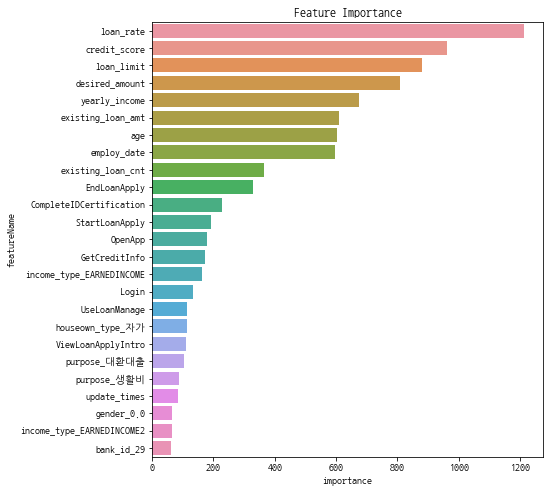

In [16]:
# 다시 그린 중요변수 플롯.

# 모델의 각 열이름을 할당해줌
# 열이름은 여기서 나오고, / 중요도는 여기서 나온다.
model.feature_name_; model.feature_importances_

import seaborn as sns
import matplotlib.pyplot as plt

plt.rc('font',family='NanumGothicCoding')

plot_df = pd.concat([pd.Series(encode_names_transform), pd.Series(model.feature_importances_)], axis=1)
plot_df.columns = ['featureName', 'importance']
plot_df = plot_df.sort_values('importance', ascending = False).head(25)

plt.figure(figsize=(7,8))
plt.title('Feature Importance')
sns.barplot(x="importance", y="featureName", data=plot_df)

plt.show()

LIME을 활용한 모델 설명.

In [17]:
predict_fn = lambda x: model.predict_proba(encoder.transform(x)).astype(float)

explainer = lime.lime_tabular.LimeTabularExplainer(X_train.to_numpy(), feature_names = feature_names,
                                                   categorical_features=categorical_features,
                                                   categorical_names=categorical_names, kernel_width=3)

In [18]:
i = 1021
exp = explainer.explain_instance(X_valid.iloc[i], predict_fn, num_features=20)
exp.show_in_notebook(show_all=False)
exp.save_to_file('lime.html')

# exp.as_pyplot_figure()
# exp.as_html()
# exp.save_to_file('lime.html')
# exp.as_pyplot_figure()
# exp.as_list() # 그림 그릴때 사용하는 값들
# exp.available_labels() # 이 요소가 무슨 값일지.

C:\Users\Nyoths\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# 모델 gridsearchCV 이용 최적 모델 탐색.

grid_model = LGBMClassifier()
params = {'n_estimators':[400,500,600,700,800], 'num_leaves':[80,100,120,140,160],
          'min_child_samples':[15,20,25],'max_depth':[-1,10,20,30],
          'learning_rate':[0.05,0.1,0.2], 'reg_alpha':[0, 0.01,0.02],
          'reg_lambda' : [0, 0.01, 0.02]}
clf = RandomizedSearchCV(grid_model, params, scoring='accuracy',
                         n_iter=200, cv=5, verbose = 2, refit = True)
clf.fit(encoder.transform(undersampled_data), undersampled_target)
print(clf.best_params_)

with open('LGBM_GRID_SEARCH(random+onehot+rep2)_MODELS.pickle', 'wb') as f:
    pickle.dump(clf, f, pickle.HIGHEST_PROTOCOL)

# predict(X) : 제일 좋은 성능을 낸 모델로 예측
# predict_proba(X) : 제일 좋은 성능을 낸 모델로 predict_proba() 호출
# best_estimator_ : 가장 좋은 성능을 낸 모델 반환

[CV] END learning_rate=0.05, max_depth=-1, min_child_samples=20, n_estimators=400, num_leaves=100, reg_alpha=0, reg_lambda=0; total time=  17.9s
[CV] END learning_rate=0.05, max_depth=-1, min_child_samples=20, n_estimators=400, num_leaves=100, reg_alpha=0, reg_lambda=0; total time=  15.9s
[CV] END learning_rate=0.05, max_depth=-1, min_child_samples=20, n_estimators=400, num_leaves=100, reg_alpha=0, reg_lambda=0; total time=  15.9s
[CV] END learning_rate=0.05, max_depth=-1, min_child_samples=20, n_estimators=400, num_leaves=100, reg_alpha=0, reg_lambda=0; total time=  15.2s
[CV] END learning_rate=0.1, max_depth=10, min_child_samples=25, n_estimators=500, num_leaves=160, reg_alpha=0, reg_lambda=0.02; total time=  13.9s
[CV] END learning_rate=0.1, max_depth=10, min_child_samples=25, n_estimators=500, num_leaves=160, reg_alpha=0, reg_lambda=0.02; total time=  14.7s
[CV] END learning_rate=0.1, max_depth=10, min_child_samples=25, n_estimators=500, num_leaves=160, reg_alpha=0, reg_lambda=0.02

최고 성능을 가진 모델.
{'reg_lambda': 0, 'reg_alpha': 0.01, 'num_leaves': 160, 'n_estimators': 800, 'min_child_samples': 25, 'max_depth': 20, 'learning_rate': 0.1}

In [ ]:
with open("LGBM_GRID_SEARCH(random+onehot+rep2)_MODELS.pickle", 'rb') as f:
    clf = pickle.load(f)

In [ ]:
f_y_pred = clf.predict(encoder.transform(full_data_train))
f_y_test = train_target.values

f_f1 = f1_score(f_y_test, f_y_pred)
print(f'f1 score : {f_f1}')

print(classification_report(f_y_test, f_y_pred))

f1 score : 0.31082322541323165
              precision    recall  f1-score   support

         0.0       0.99      0.78      0.88   9709675
         1.0       0.19      0.88      0.31    554711

    accuracy                           0.79  10264386
   macro avg       0.59      0.83      0.59  10264386
weighted avg       0.95      0.79      0.84  10264386



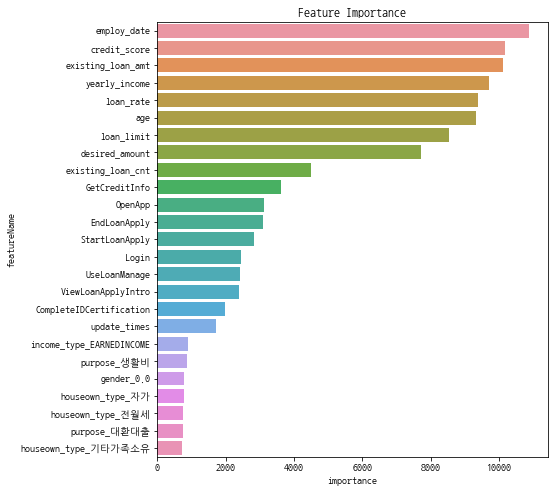

In [ ]:

# 모델의 각 열이름을 할당해줌
# 열이름은 여기서 나오고, / 중요도는 여기서 나온다.
clf.best_estimator_.feature_name_; clf.best_estimator_.feature_importances_

import seaborn as sns
import matplotlib.pyplot as plt

plt.rc('font',family='NanumGothicCoding')

plot_df = pd.concat([pd.Series(encode_names_transform), pd.Series(clf.best_estimator_.feature_importances_)], axis=1)
plot_df.columns = ['featureName', 'importance']
plot_df = plot_df.sort_values('importance', ascending = False).head(25)

plt.figure(figsize=(7,8))
plt.title('Feature Importance')
sns.barplot(x="importance", y="featureName", data=plot_df)

plt.show()

In [24]:
test_pred = clf.predict(encoder.transform(full_data_test))

full_data_test_pred = pd.concat([test_appid, test_usrid, full_data_test, pd.Series(test_pred,name = 'is_applied')], axis = 1)

full_data_test_pred.to_csv('full_data_test_pred.csv', index = False)

In [25]:
predict_fn2 = lambda x: clf.predict_proba(encoder.transform(x)).astype(float)

# 원래는 X_valid 자리에 X_train이 들어가야함/ 아 진짬ㅆㄹ헌이ㅏㅓㅁ호ㅓㅏㅣㅍㄾㅊ프ㅏㅣㅁㄴ어ㅗㅜㅎ러ㅏㅐㅍ초터ㅏㅣ
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.to_numpy(), feature_names = feature_names,
                                                   categorical_features=categorical_features,
                                                   categorical_names=categorical_names, kernel_width=3)

# explainer의 매개변수  class_names=['non_applied', 'applied'], 뺐음. 0, 1이 뭐로 바뀌는지 몰라서.
# https://github.com/marcotcr/lime/issues/293 => to_numpy()로 판다스 바로 넣지 말기.

C:\Users\Nyoths\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
C:\Users\Nyoths\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


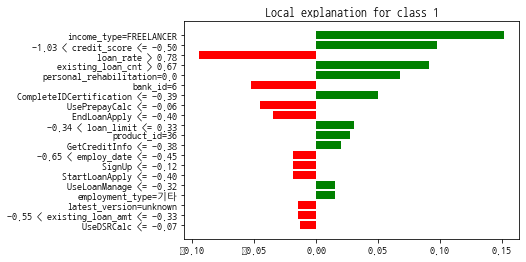

In [26]:
i = 7176
exp = explainer.explain_instance(X_valid.iloc[i], predict_fn2, num_features=20)
exp.as_pyplot_figure()
exp.save_to_file('lime_output1.html')

C:\Users\Nyoths\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
C:\Users\Nyoths\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


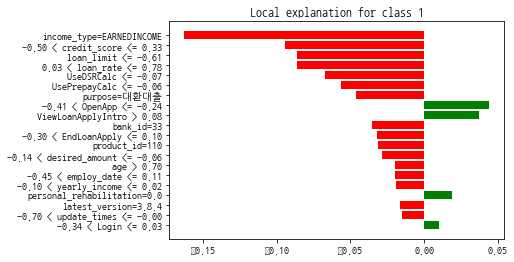

In [27]:
i = 4042
exp = explainer.explain_instance(X_valid.iloc[i], predict_fn2, num_features=20)
exp.as_pyplot_figure()
exp.save_to_file('lime_output2.html')

In [28]:
# 개별 요소 예측. 중요변수 판단(1만개 대상 샘플링한 결과를 일반화.)

pred_df = undersampled_data.sample(10000)

pred0_df = []
pred1_df = []
pd.DataFrame(exp.as_list(), columns = ['Feature', 'Importance'])
for i in tqdm(range(len(pred_df))):
    exp = explainer.explain_instance(pred_df.iloc[i], predict_fn2, num_features=20)
    if exp.available_labels() == [1]:
        pred1_df.append(pd.DataFrame(exp.as_list(), columns = ['Feature', 'Importance']))

    elif exp.available_labels() == [0]:
        pred0_df.append(pd.DataFrame(exp.as_list(), columns = ['Feature', 'Importance']))

print(f'undersampleing 데이터 수 : {len(undersampled_data)}')
print(f'0번 예측 개수 : {len(pred0_df)}')
print(f'1번 예측 개수 : {len(pred1_df)}')

pred0_df = pd.concat(pred0_df, axis = 0)
pred1_df = pd.concat(pred1_df, axis = 0)

pred0_df.to_csv('pred0df_feature_importance')
pred1_df.to_csv('pred1df_feature_importance')

  0%|          | 0/10000 [00:00<?, ?it/s]C:\Users\Nyoths\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
  0%|          | 1/10000 [00:03<9:49:24,  3.54s/it]C:\Users\Nyoths\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
  0%|          | 2/10000 [00:07<9:50:13,  3.54s/it]C:\Users\Nyoths\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
  0%|          | 3/10000 [00:10<9:53:29,  3.56s/it]C:\Users\Nyoths\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
  0%|          | 4/10000 [00:14<9:53:01,  3.56s/it]C:\Users\Nyoths\anaconda3\lib\site-

undersampleing 데이터 수 : 1109422
0번 예측 개수 : 0
1번 예측 개수 : 10000


ValueError: No objects to concatenate

In [30]:
pred1_df = pd.concat(pred1_df, axis = 0)

In [ ]:
# 이제 이런식으로 보면 되겠지.
pred0_df.groupby('Feature').mean().sort_values('Importance')

In [ ]:
pred0_df.groupby('Feature').mean().sort_values('Importance', ascending = False)

In [31]:
pred1_df.groupby('Feature').mean().sort_values('Importance')

Importance
Feature                          
credit_score > 0.33     -0.353422
bank_id=28              -0.262722
product_id=81           -0.182075
product_id=16           -0.164981
product_id=108          -0.164716
...                           ...
latest_version=3.5.0     0.193995
latest_version=413       0.195612
latest_version=399       0.214806
bank_id=4                0.230352
credit_score <= -1.03    0.296612

[379 rows x 1 columns]

In [32]:
pred1_df.groupby('Feature').mean().sort_values('Importance', ascending = False)

Importance
Feature                          
credit_score <= -1.03    0.296612
bank_id=4                0.230352
latest_version=399       0.214806
latest_version=413       0.195612
latest_version=3.5.0     0.193995
...                           ...
product_id=108          -0.164716
product_id=16           -0.164981
product_id=81           -0.182075
bank_id=28              -0.262722
credit_score > 0.33     -0.353422

[379 rows x 1 columns]

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rc('font',family='NanumGothicCoding')

plot_df = pred0_df.groupby('Feature').mean().sort_values('Importance').head(25).reset_index()
plot_df.columns = ['feature', 'importance']

plt.figure(figsize=(7,8))
plt.title('Feature Importance')
sns.barplot(x="importance", y="feature", data=plot_df)

plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rc('font',family='NanumGothicCoding')

plot_df = pred0_df.groupby('Feature').mean().sort_values('Importance', ascending = False).head(25).reset_index()
plot_df.columns = ['feature', 'importance']

plt.figure(figsize=(7,8))
plt.title('Feature Importance')
sns.barplot(x="importance", y="feature", data=plot_df)

plt.show()

C:\Users\Nyoths\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


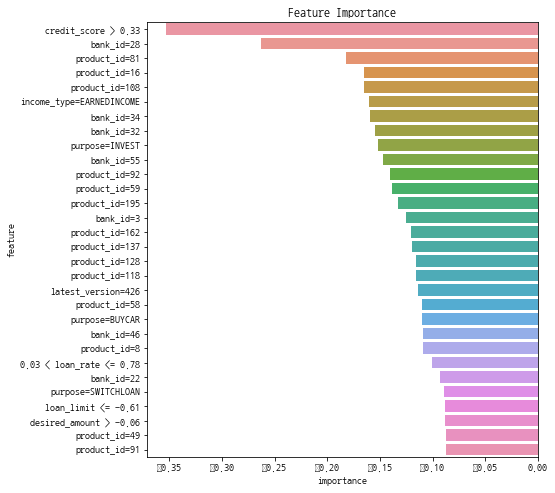

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rc('font',family='NanumGothicCoding')

plot_df = pred1_df.groupby('Feature').mean().sort_values('Importance').head(30).reset_index()
plot_df.columns = ['feature', 'importance']

plt.figure(figsize=(7,8))
plt.title('Feature Importance')
sns.barplot(x="importance", y="feature", data=plot_df)

plt.show()

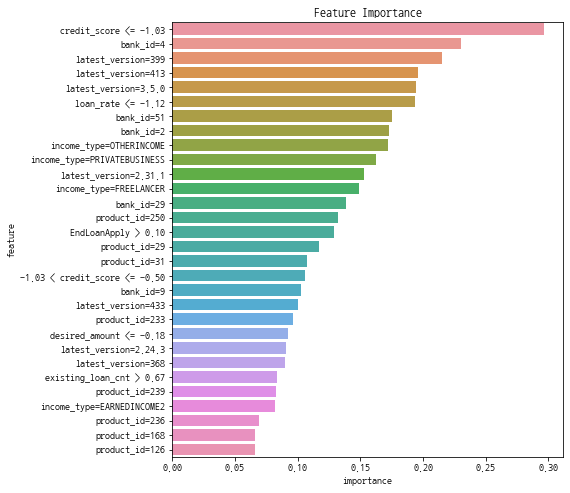

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rc('font',family='NanumGothicCoding')

plot_df = pred1_df.groupby('Feature').mean().sort_values('Importance', ascending = False).head(30).reset_index()
plot_df.columns = ['feature', 'importance']

plt.figure(figsize=(7,8))
plt.title('Feature Importance')
sns.barplot(x="importance", y="feature", data=plot_df)

plt.show()